# Unsupervised Prediction Model

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sn
from math import log
import re
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [94]:
KM_train = pd.read_csv('kmean_training.csv')
KM_test = pd.read_csv('kmean_test.csv')

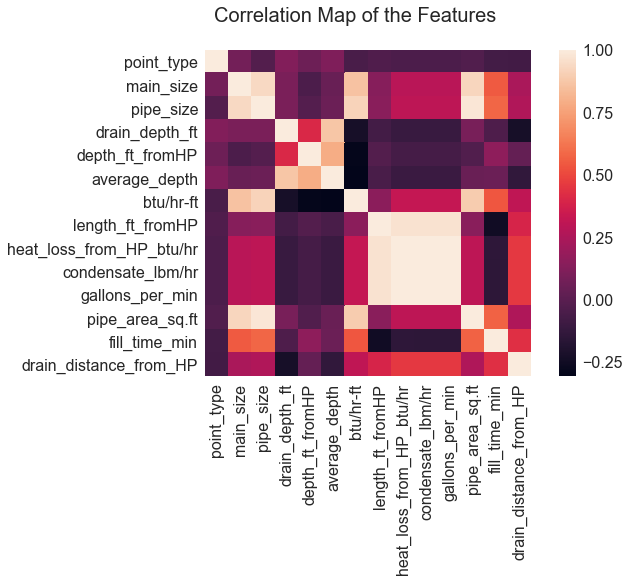

In [184]:
KM_Train_Heat=KM_train[['point_type','main_size','pipe_size','drain_depth_ft','depth_ft_fromHP', 'average_depth','btu/hr-ft','length_ft_fromHP','heat_loss_from_HP_btu/hr','condensate_lbm/hr','gallons_per_min','pipe_area_sq.ft','fill_time_min','drain_distance_from_HP']]
cor = KM_Train_Heat.corr() #Calculate the correlation of the above variables

plt.subplots(figsize=(10,6))
plt.suptitle('Correlation Map of the Features', fontsize=20, )
sns.set(font_scale=1.6)
sns.heatmap(cor, square = True) #Plot the correlation as heat map

## Feature Selection using Random Forest

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from rfpimp import *

import warnings
warnings.filterwarnings('ignore')

def mkdf(columns, importances):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=False)
    return I

In [205]:
df1 = pd.read_csv("train_labelfor_RF_FS.csv")

features = ['point_type','main_size','pipe_size','drain_depth_ft', 'depth_ft_fromHP','average_depth','btu/hr-ft','length_ft_fromHP', 'heat_loss_from_HP_btu/hr','condensate_lbm/hr','gallons_per_min','pipe_area_sq.ft','fill_time_min','drain_distance_from_HP','label']
df = df1[features].copy()
#df.to_csv("RF_undum", index=False)
#df1.head(5)

0.9712320200125079
0.9712320200125079


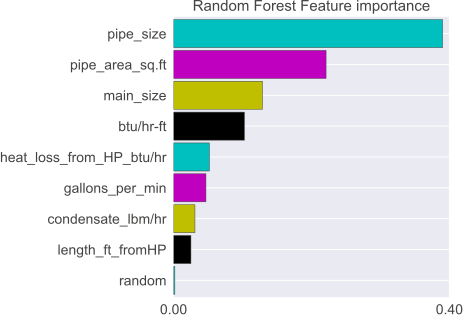

In [204]:
base_rf = RandomForestClassifier(n_estimators=100, criterion='gini',
                                 min_samples_leaf=10,
                                 n_jobs=-1,
                                 oob_score=True, random_state=0, bootstrap=True)

X_train, y_train = df.drop('label',axis=1), df['label']

rf = clone(base_rf)
rf.fit(X_train, y_train)
print(rf.oob_score_)
I = mkdf(X_train.columns,rf.feature_importances_)            
viz = plot_importances(I, imp_range=(0,.4))
viz.save('../cls_dflt.svg')
viz.close()

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train2))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)
print(rf2.oob_score_)
I = mkdf(X_train2.columns,rf2.feature_importances_)

fig, ax = plt.subplots(figsize=(10, 8))
plot_importances(I, imp_range=(0,.40), color='cmyk', title="Random Forest Feature importance", label_fontsize=14, width=7, minheight=5,)
viz.save('../PipelineProject/featimp.svg')
viz

## Final Features

In [99]:
df_num=KM_train.drop(['ID','TID','structureID','address','route','stop','plate','fill_time_min','average_depth','point_type','drain_distance_from_HP','drain_depth_ft', 'depth_ft_fromHP'], axis=1)

In [100]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_num2 = scaler.fit_transform(df_num) 

In [101]:
df_num.head(3)

,main_size,pipe_size,btu/hr-ft,length_ft_fromHP,heat_loss_from_HP_btu/hr,condensate_lbm/hr,gallons_per_min,pipe_area_sq.ft
0,8,8,312,759.67,237017.04,275,0.549560,0.347497
1,8,8,312,69.46,21671.52,25,0.049960,0.347497
2,8,8,320,365.96,117107.20,136,0.271783,0.347497


## ELbow Method

Text(0,0.5,'Cluster Error')

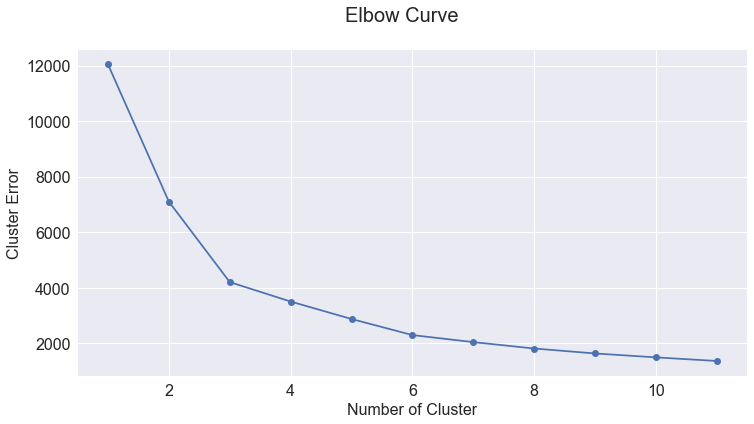

In [165]:
from sklearn.cluster import KMeans
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.plotly as py

num_cluster = range(1, 12)
label = []


for i in range(1,12):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10).fit(df_num2)
    label.append(kmeans.inertia_)
kmeans_df = pd.DataFrame({"num_clusters":num_cluster, "cluster_errors": label})

plt.figure(figsize=(12,6))
plt.plot(kmeans_df.num_clusters, kmeans_df.cluster_errors, marker = "o")
plt.suptitle('Elbow Curve', fontsize=20)
plt.xlabel('Number of Cluster', fontsize=16)
plt.ylabel('Cluster Error', fontsize=16)

## Silhouette Analysis

In [104]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [105]:
df_num1 = pd.DataFrame({'main_size':df_num2[:,0],'pipe_size':df_num2[:,1],'btu/hr-ft':df_num2[:,2],'length_ft_fromHP':df_num2[:,3],'heat_loss_from_HP_btu/hr':df_num2[:,4],'condensate_lbm/hr':df_num2[:,5],'gallons_per_min':df_num2[:,6],'pipe_area_sq.ft':df_num2[:,7]})

For n_clusters = 2 The average silhouette_score is : 0.4225890336490509


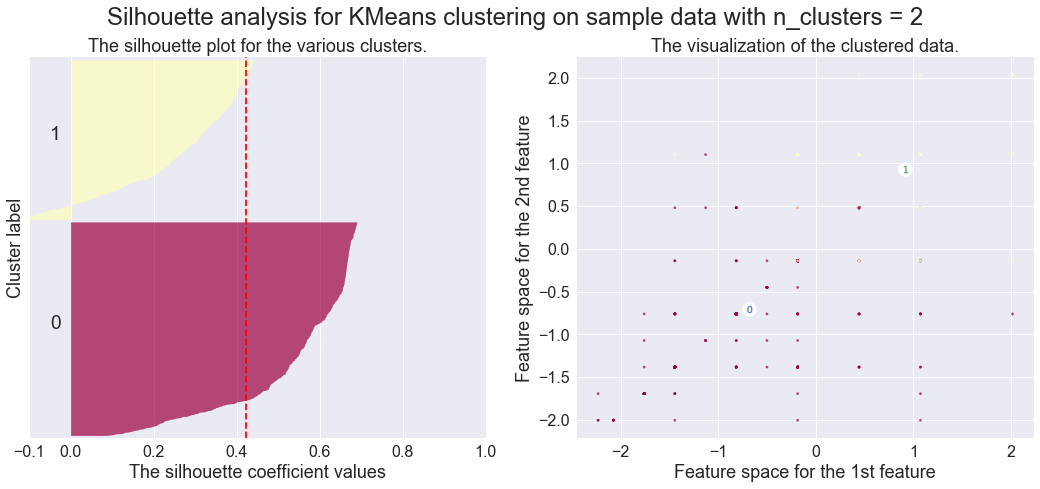

For n_clusters = 3 The average silhouette_score is : 0.45792871606958196


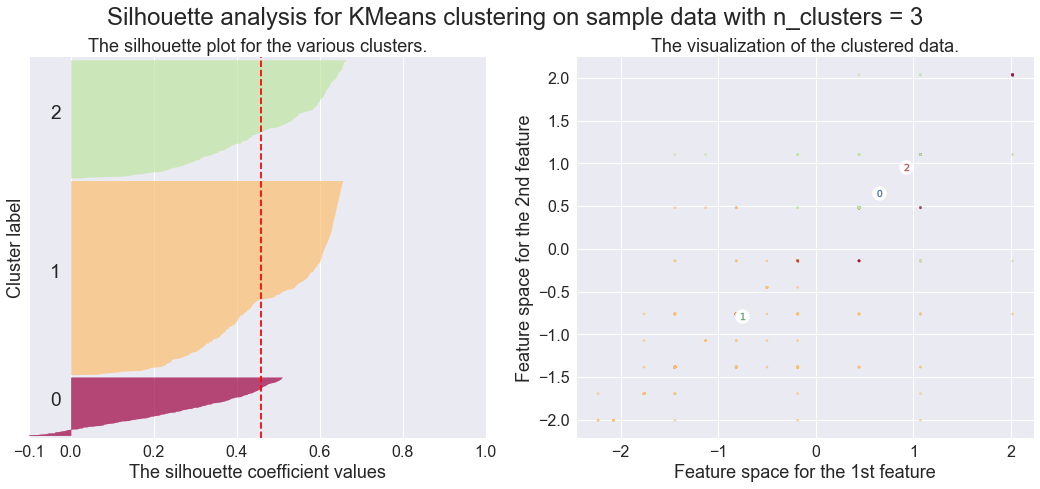

In [166]:
cluster_range = range(2, 4)

for n_clusters in cluster_range:
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(df_num1) + (n_clusters + 1) * 10])

  clusterer = KMeans(n_clusters=n_clusters, init='k-means++',n_init=10, max_iter=300)
  cluster_labels = clusterer.fit_predict(df_num1)

  silhouette_avg = silhouette_score(df_num1, cluster_labels, metric='euclidean')
  print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

  sample_silhouette_values = silhouette_samples(df_num1, cluster_labels, metric='euclidean')

  y_lower = 10
  for i in range(n_clusters):
      ith_cluster_silhouette_values = \
          sample_silhouette_values[cluster_labels == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = plt.get_cmap('Spectral')(float(i) / n_clusters)
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10  # 10 for the 0 samples

  ax1.set_title("The silhouette plot for the various clusters.", fontsize = 18.0)
  ax1.set_xlabel("The silhouette coefficient values", fontsize = 18.0)
  ax1.set_ylabel("Cluster label", fontsize = 18.0)

  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  colors = plt.get_cmap('Spectral')(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(df_num1.iloc[:, 0], df_num1.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
              c=colors)

  centers = clusterer.cluster_centers_
  ax2.scatter(centers[:, 0], centers[:, 1],
              marker='o', c="white", alpha=1, s=200)

  for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

  ax2.set_title("The visualization of the clustered data.", fontsize = 18.0)
  ax2.set_xlabel("Feature space for the 1st feature", fontsize = 18.0)
  ax2.set_ylabel("Feature space for the 2nd feature", fontsize = 18.0)

  plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=24)

  plt.show()

## K-Means Clustering Model

In [107]:
KMmodel = KMeans(n_clusters=3, init='k-means++',max_iter=300,n_init=10).fit(df_num2)
label=KMmodel.labels_
centers=KMmodel.cluster_centers_
y_kmeans=KMmodel.predict(df_num2)

In [108]:
df_label = pd.DataFrame({'label':label[:]})

In [109]:
kmean_label=pd.concat([df_num, df_label], axis = 1, join='inner')

In [65]:
kmean_label.to_csv('kmean_train_label.csv',index=False)

## Run Test Sample

In [110]:
df_test=KM_test.drop(['ID','TID','structureID','address','route','stop','plate','fill_time_min','average_depth','point_type','drain_distance_from_HP','drain_depth_ft', 'depth_ft_fromHP'], axis=1)
df_test1 = scaler.transform(df_test)

In [206]:
#df_test.head(3)

In [112]:
test_label=KMmodel.predict(df_test1)
test_label

array([1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1])

In [113]:
dftest_label = pd.DataFrame({'label':test_label[:]})

In [114]:
testlabel=pd.concat([df_test, dftest_label], axis = 1, join='inner')

In [72]:
testlabel.to_csv('kmean_test_label.csv',index=False)

#Label = '0' has high probability of leak locations

## K Means Clustering Plot

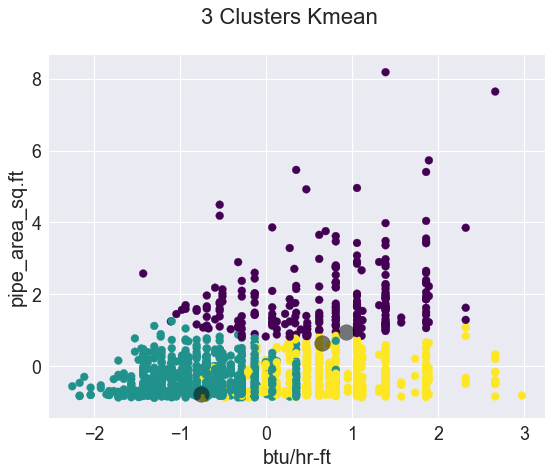

In [167]:
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(df_num2[:,2], df_num2[:,4], c=y_kmeans, s=50, cmap='viridis')
plt.suptitle('3 Clusters Kmean', fontsize=20, )
plt.xlabel('btu/hr-ft', fontsize = 18.0)
plt.ylabel('pipe_area_sq.ft', fontsize = 18.0)


centers=KMmodel.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


## Feature Importance using Logistic Regression

In [200]:
import numpy as np    
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# df = pd.read_csv("LR_FeatImp.csv")

X= df.drop(['label'], axis=1)
y=df['label']

#Scale your data
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)

clf = LogisticRegression(random_state = 0)
clf.fit(X_scaled, y)

feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

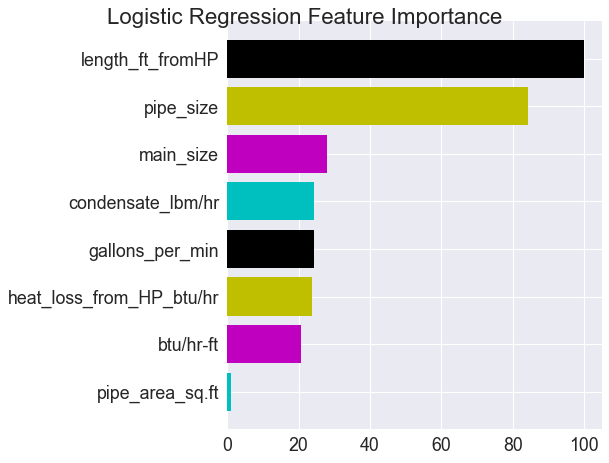

In [202]:
featfig = plt.figure(figsize=(8, 6), dpi=80)
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='cmyk')
plt.suptitle('Logistic Regression Feature Importance', fontsize=20)
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=16)
#featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

## Logistic Regression and Confusion Matrix

In [118]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

LR_train = pd.read_csv('kmean_train_label.csv')
X_train =LR_train.drop(['label'], axis=1)
y_train =LR_train['label']
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [119]:
LR_test = pd.read_csv('LR_test_label.csv')
X_test =LR_test.drop(['label'], axis=1)
y_test =LR_test['label']

In [120]:
y_pred=logreg.predict(X_test)

In [121]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[68, 18,  8],
       [ 0,  0,  0],
       [ 0,  0,  0]], dtype=int64)

Text(0.5,257.44,'Predicted label')

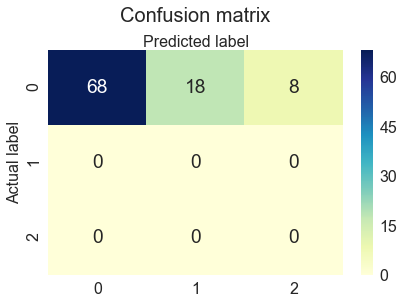

In [164]:
class_names=[0,1,2] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1, fontsize=20)
plt.ylabel('Actual label', fontsize=16)
plt.xlabel('Predicted label', fontsize=16)

In [185]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.723404255319149
